In [112]:
import os 
import pathlib
import pickle as pkl
#import pyarrow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import itertools
import re
#import sklearn
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, RocCurveDisplay, average_precision_score, precision_recall_curve, PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, label_binarize, LabelBinarizer, StandardScaler, RobustScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
pd.set_option('display.max_columns', None)

In [86]:
def load_prepped_data(feature_path = "../data/preprocessed/features.pkl", 
                      block_path = "../data/preprocessed/block_array.pkl"):
    """ 
    Load prepped data (features, X and y) and block array (with block counts). Create df from 
    block_array and split each block into support, neutral and oppose columns. append the resulting
    df to X and return. (also returned: the list of bill ids in same order as X df)
    """
    with open(feature_path, 'rb') as file:
        X, y = pkl.load(file)        
    with open(block_path, 'rb') as file:
        block_array, block1_ls, bill_ls = pkl.load(file)
    
    block_col_names = np.char.add("block1_", block1_ls) #define column names 
    block_df = pd.DataFrame.from_records(block_array, columns=block_col_names)
    block_df_split = pd.DataFrame()                     #create empty df for split cols
    #populate empty df
    for col in block_df.columns:
        block_df_split[[(col+"_s"), (col+"_n"), (col+"_o")]] = pd.DataFrame(block_df[col].to_list())
    #add lobby column(if no positions on the bill the row sum will be 0 i.e. no_lobby)
    block_df_split["lobbied"] = np.where(block_df_split.sum(axis=1)>0, 'lobby', 'no_lobby')
    #join X and block df 
    X = X.join(block_df_split)
    return X, y, bill_ls

In [87]:
def split_features(feature_path = "../data/preprocessed/features.pkl", 
                   block_path = "../data/preprocessed/block_array.pkl" ):
    """ Load data (X, y) and split to train and test set """ 
    #X, y = load_prep_features(data_path) # load prepped data
    X, y, bill_ls = load_prepped_data()
    
    lb = LabelBinarizer()                # define label binarizer (y)
    y = lb.fit_transform(y)              # fit and transform (y)
    y_classes = lb.classes_              # extract classes (y)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=104, test_size=0.20, shuffle=True, stratify=y)
    return X_train, X_test, y_train, y_test, y_classes, bill_ls

In [88]:
X_train, X_test, y_train, y_test, y_classes, bill_ls = split_features()

/tmp/ipykernel_64888/2301501355.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  block_df_split[[(col+"_s"), (col+"_n"), (col+"_o")]] = pd.DataFrame(block_df[col].to_list())
/tmp/ipykernel_64888/2301501355.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  block_df_split[[(col+"_s"), (col+"_n"), (col+"_o")]] = pd.DataFrame(block_df[col].to_list())
/tmp/ipykernel_64888/2301501355.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfor

In [89]:
X_train

,state,ncsl_metatopics,cha,chamber,dem,rep,majority,minority,dem_mean,rep_mean,...,block1_40_s,block1_40_n,block1_40_o,block1_202_s,block1_202_n,block1_202_o,block1_92_s,block1_92_n,block1_92_o,lobbied
106895,NJ,[M],S,-0.945,-1.054,0.089,-1.054,0.089,-1.052374,0.106960,...,0,0,0,0,0,0,0,0,0,no_lobby
31222,MA,[M],S,-1.078,-1.120,0.141,-1.120,0.141,-1.107051,0.128131,...,0,0,0,0,0,0,0,0,0,lobby
105099,NJ,[M],H,-1.032,-1.149,0.053,-1.149,0.053,-1.115470,0.099696,...,0,0,0,0,0,0,0,0,0,no_lobby
102451,NJ,[M],H,-1.032,-1.149,0.053,-1.149,0.053,-1.115470,0.099696,...,0,0,0,0,0,0,0,0,0,lobby
95881,NJ,[M],H,-1.047,-1.138,0.053,-1.138,0.053,-1.102124,0.125041,...,0,0,0,0,0,0,0,0,0,no_lobby
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34961,MA,[M],H,-1.084,-1.130,0.151,-1.130,0.151,-1.164636,0.167204,...,0,0,0,0,0,0,0,0,0,no_lobby
100904,NJ,[M],S,-0.945,-1.054,0.089,-1.054,0.089,-1.052374,0.106960,...,0,0,0,0,0,0,0,0,0,no_lobby
20783,MA,[M],H,-1.071,-1.108,0.184,-1.108,0.184,-1.117378,0.213987,...,0,0,0,0,0,0,0,0,0,lobby
30158,MA,[M],H,-1.083,-1.121,0.158,-1.121,0.158,-1.140544,0.168170,...,0,0,0,0,0,0,0,0,0,no_lobby


In [113]:
X_dtypes = X_train.dtypes.to_frame().T
(X_dtypes)

,state,ncsl_metatopics,cha,chamber,dem,rep,majority,minority,dem_mean,rep_mean,diffs,distance,block1_146_s,block1_146_n,block1_146_o,block1_195_s,block1_195_n,block1_195_o,block1_45_s,block1_45_n,block1_45_o,block1_5_s,block1_5_n,block1_5_o,block1_51_s,block1_51_n,block1_51_o,block1_130_s,block1_130_n,block1_130_o,block1_26_s,block1_26_n,block1_26_o,block1_196_s,block1_196_n,block1_196_o,block1_161_s,block1_161_n,block1_161_o,block1_142_s,block1_142_n,block1_142_o,block1_116_s,block1_116_n,block1_116_o,block1_190_s,block1_190_n,block1_190_o,block1_204_s,block1_204_n,block1_204_o,block1_58_s,block1_58_n,block1_58_o,block1_28_s,block1_28_n,block1_28_o,block1_27_s,block1_27_n,block1_27_o,block1_100_s,block1_100_n,block1_100_o,block1_81_s,block1_81_n,block1_81_o,block1_79_s,block1_79_n,block1_79_o,block1_12_s,block1_12_n,block1_12_o,block1_107_s,block1_107_n,block1_107_o,block1_180_s,block1_180_n,block1_180_o,block1_115_s,block1_115_n,block1_115_o,block1_191_s,block1_191_n,block1_191_o,block1_80_s,block1_80_n,block1_80_o,block1_86_s,block1_86_n,block1_86_o,block1_32_s,block1_32_n,block1_32_o,block1_255_s,block1_255_n,block1_255_o,block1_262_s,block1_262_n,block1_262_o,block1_212_s,block1_212_n,block1_212_o,block1_169_s,block1_169_n,block1_169_o,block1_200_s,block1_200_n,block1_200_o,block1_70_s,block1_70_n,block1_70_o,block1_19_s,block1_19_n,block1_19_o,block1_181_s,block1_181_n,block1_181_o,block1_238_s,block1_238_n,block1_238_o,block1_231_s,block1_231_n,block1_231_o,block1_110_s,block1_110_n,block1_110_o,block1_209_s,block1_209_n,block1_209_o,block1_90_s,block1_90_n,block1_90_o,block1_62_s,block1_62_n,block1_62_o,block1_220_s,block1_220_n,block1_220_o,block1_23_s,block1_23_n,block1_23_o,block1_119_s,block1_119_n,block1_119_o,block1_149_s,block1_149_n,block1_149_o,block1_230_s,block1_230_n,block1_230_o,block1_203_s,block1_203_n,block1_203_o,block1_250_s,block1_250_n,block1_250_o,block1_140_s,block1_140_n,block1_140_o,block1_57_s,block1_57_n,block1_57_o,block1_31_s,block1_31_n,block1_31_o,block1_7_s,block1_7_n,block1_7_o,block1_128_s,block1_128_n,block1_128_o,block1_111_s,block1_111_n,block1_111_o,block1_41_s,block1_41_n,block1_41_o,block1_20_s,block1_20_n,block1_20_o,block1_257_s,block1_257_n,block1_257_o,block1_148_s,block1_148_n,block1_148_o,block1_118_s,block1_118_n,block1_118_o,block1_223_s,block1_223_n,block1_223_o,block1_185_s,block1_185_n,block1_185_o,block1_150_s,block1_150_n,block1_150_o,block1_265_s,block1_265_n,block1_265_o,block1_33_s,block1_33_n,block1_33_o,block1_0_s,block1_0_n,block1_0_o,block1_48_s,block1_48_n,block1_48_o,block1_72_s,block1_72_n,block1_72_o,block1_138_s,block1_138_n,block1_138_o,block1_103_s,block1_103_n,block1_103_o,block1_172_s,block1_172_n,block1_172_o,block1_243_s,block1_243_n,block1_243_o,block1_96_s,block1_96_n,block1_96_o,block1_112_s,block1_112_n,block1_112_o,block1_30_s,block1_30_n,block1_30_o,block1_215_s,block1_215_n,block1_215_o,block1_113_s,block1_113_n,block1_113_o,block1_73_s,block1_73_n,block1_73_o,block1_165_s,block1_165_n,block1_165_o,block1_123_s,block1_123_n,block1_123_o,block1_76_s,block1_76_n,block1_76_o,block1_65_s,block1_65_n,block1_65_o,block1_1_s,block1_1_n,block1_1_o,block1_53_s,block1_53_n,block1_53_o,block1_133_s,block1_133_n,block1_133_o,block1_44_s,block1_44_n,block1_44_o,block1_101_s,block1_101_n,block1_101_o,block1_174_s,block1_174_n,block1_174_o,block1_11_s,block1_11_n,block1_11_o,block1_15_s,block1_15_n,block1_15_o,block1_34_s,block1_34_n,block1_34_o,block1_99_s,block1_99_n,block1_99_o,block1_39_s,block1_39_n,block1_39_o,block1_21_s,block1_21_n,block1_21_o,block1_38_s,block1_38_n,block1_38_o,block1_24_s,block1_24_n,block1_24_o,block1_17_s,block1_17_n,block1_17_o,block1_13_s,block1_13_n,block1_13_o,block1_94_s,block1_94_n,block1_94_o,block1_18_s,block1_18_n,block1_18_o,block1_89_s,block1_89_n,block1_89_o,block1_122_s,block1_122_n,block1_122_o,block1_121_s,block1_121_n,block1_121_o,block1_46_s,block1_46_n,block1_46_o,block1_66_s,block1_66_n,block1_66_o,block1_50_s,

Features: 
- binary features (OneHotEncoder(drop="if_binary")): 
    - 'cha': chamber (H: House or S: Senate)
    - 'lobbied': whether the bill was lobbied on (lobby or no_lobby)

- categorical features (OneHotEncoder()): 
    - 'state': the state the bill is from (IA, MA, NE, NJ, RI, WI)

- multi-categorical features(CountVectorizer()): 
    - 'ncsl_metatopics': metatopics assigned to the bill (18 different metatopics)

- numerical features (StandardScaler()): 
    - 'chamber', 'dem' ,'rep', 'majority', 'minority': medians by chamber 
    - 'dem_mean', 'rep_mean': means by chamber 
    - 'diffs', 'distance': distances between party medians and average between members

'neut_blocks',
       'opp_blocks', 'sup_blocks', 'neut_counts', 'opp_counts', 'sup_counts',
      

In [98]:
#transformers
categorical_transformer=Pipeline(
    steps=[('encoder', OneHotEncoder(sparse_output=False))])

multi_categorical_transformer=Pipeline(
    steps=[('encoder', CountVectorizer(analyzer=lambda lst: lst))])

binary_transformer=Pipeline(
    steps=[('encoder', OneHotEncoder(sparse_output=False, drop="if_binary"))])

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())])

count_transformer = Pipeline(
    steps=[("scaler", RobustScaler())])


In [99]:
ct = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, ["state"]),
        ("multi_cat", multi_categorical_transformer, "ncsl_metatopics"),
        ("bin", binary_transformer, ["cha", "lobbied"]),
        ("num", numeric_transformer, make_column_selector(dtype_include="float64")), 
        ("count", count_transformer, make_column_selector(dtype_include="int32"))
    ],
    remainder='passthrough', 
    force_int_remainder_cols = False, sparse_threshold=0
)

In [133]:
#LOGREG PIPELINE
clf_pipeline_LR = Pipeline(
    steps=[("preprocessor", ct), 
           ("classifier", LogisticRegression(
            random_state=37, max_iter=10000, class_weight="balanced", solver="newton-cholesky", 
            verbose=3))
    ]
)

In [134]:
clf_pipeline_LR.fit(X_train, y_train)

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Newton iter=1
  Backtracking Line Search
    eps=16 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.12620108440038347 <= -0.000113114916900131 True
    line search successful after 1 iterations with loss=0.5669460961595618.
  Check Convergence
    1. max |gradient| 0.029395513276833582 <= 0.0001 False
Newton iter=2
  Backtracking Line Search
    eps=16 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.009548662474060388 <= -8.005707446376825e-06 True
    line search successful after 1 iterations with loss=0.5573974336855014.
  Check Convergence
    1. max |gradient| 0.003938969539327922 <= 0.0001 False
Newton iter=3
  Backtracking Line Search
    eps=16 * finfo.eps=3.552713678800501e-15
    line search iteration=1, step size=1
      check loss improvement <= armijo term: -0.001302202044401568 <= -1.0939145386660153e-06 True
    line search 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.7s finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['state']),
                                                 ('multi_cat',
                                                  Pipeline(steps=[('encoder',
                                                                   CountVectorizer(analyzer=<function <lambda> at 0x7fbd2ddfccc0>))]),
                                                  'ncsl_metatopics'),
                                                 ('bin'...
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbe3f3fab10>),
                                                 ('count',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbe3f3fab40>)])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=10000,
                                    random_state=37, solver='newton-cholesky',
                                    verbose=3))])

In [135]:
y_pred = clf_pipeline_LR.predict(X_test)
print(classification_report(y_test, y_pred, target_names=y_classes))

              precision    recall  f1-score   support

      failed       0.93      0.81      0.87     22505
      passed       0.29      0.56      0.39      3061

    accuracy                           0.78     25566
   macro avg       0.61      0.69      0.63     25566
weighted avg       0.86      0.78      0.81     25566



In [130]:
#MLP PIPELINE
clf_pipeline_mlp = Pipeline(
    steps=[("preprocessor", ct), 
           ("classifier", MLPClassifier(early_stopping=True,
            random_state=37, max_iter=1000, verbose=3))
    ]
)

In [131]:
clf_pipeline_mlp.fit(X_train, y_train)

/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.33458989
Validation score: 0.882566
Iteration 2, loss = 0.29778081
Validation score: 0.885304
Iteration 3, loss = 0.28943393
Validation score: 0.885206
Iteration 4, loss = 0.28400714
Validation score: 0.887259
Iteration 5, loss = 0.27901900
Validation score: 0.885597
Iteration 6, loss = 0.27451849
Validation score: 0.886086
Iteration 7, loss = 0.27104922
Validation score: 0.884619
Iteration 8, loss = 0.26747603
Validation score: 0.884619


/work/DPF_exam/env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['state']),
                                                 ('multi_cat',
                                                  Pipeline(steps=[('encoder',
                                                                   CountVectorizer(analyzer=<function <lambda> at 0x7fbd2ddfccc0>))]),
                                                  'ncsl_metatopics'),
                                                 ('bin'...
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbe3f3fab10>),
                                                 ('count',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbe3f3fab40>)])),
                ('classifier',
                 MLPClassifier(early_stopping=True, max_iter=1000,
                               random_state=37, verbose=3))])

In [127]:
y_pred = clf_pipeline.predict(X_test)

In [128]:
print(classification_report(y_test, y_pred, target_names=y_classes))

              precision    recall  f1-score   support

      failed       0.93      0.81      0.87     22505
      passed       0.29      0.56      0.39      3061

    accuracy                           0.78     25566
   macro avg       0.61      0.69      0.63     25566
weighted avg       0.86      0.78      0.81     25566



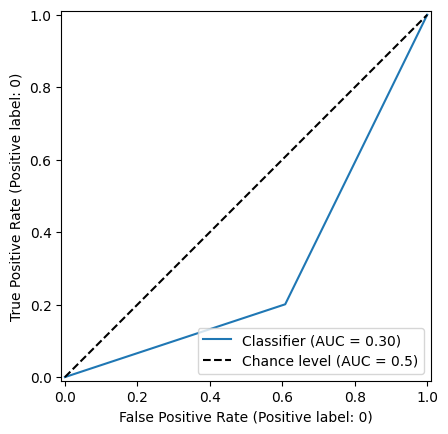

In [208]:
RocCurveDisplay.from_predictions(y_test, y_pred, plot_chance_level=True, pos_label=0)

In [223]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred)

TypeError: unhashable type: 'numpy.ndarray'

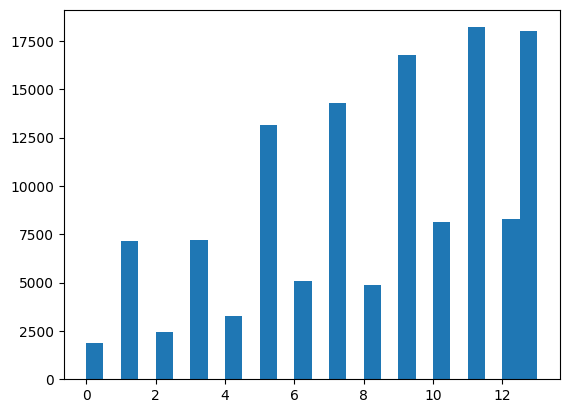

In [ ]:
#hist of bill year
plt.hist(X_train_tr[0:, 6], bins=26)
plt.show()

In [ ]:


#block features: 
enc_blocks, names_blocks = encode_blocks(X_df, col_blocks=["neut_blocks", "opp_blocks", "sup_blocks"])

X_n = transform_block_counts(X_df, blocks_col="neut_blocks", 
                                               counts_col="neut_counts", fitted_encoder=enc_blocks)
X_s = transform_block_counts(X_df, blocks_col="sup_blocks", 
                                               counts_col="sup_counts", fitted_encoder=enc_blocks)
X_o = transform_block_counts(X_df, blocks_col="opp_blocks", 
                                               counts_col="opp_counts", fitted_encoder=enc_blocks)                                               


In [77]:
fitted_encoder = enc_blocks
X_df = X_test.copy()
blocks_col = "neut_blocks"
counts_col = "neut_counts"
X_blocks = fitted_encoder.transform(X_df[blocks_col]).toarray()
X_counts = X_df[counts_col]

for i, (row_blocks, row_counts) in enumerate(zip(X_blocks, X_counts), start=0):
    if type(row_counts) == list:
        inds = np.asarray(row_blocks==1).nonzero()[0]
        for j, (index, count) in enumerate(zip(inds, row_counts), start=0):
            row_blocks[index] = count

In [ ]:
def transform_block_counts(X_df, blocks_col:str, counts_col:str, fitted_encoder):
    """ 
    Uses a fitted encoder to transform block features, then the respective count data is used inputted
    to to features. It returns the transformed feature. It takes the df with the features (X_df), the
    column name with block assignments (blocks_col), the column name with the count data, and the 
    fitted encoder.  
    """
    X_blocks = fitted_encoder.transform(X_df[blocks_col]).toarray()
    X_counts = X_df[counts_col]
    
    for i, (row_blocks, row_counts) in enumerate(zip(X_blocks, X_counts), start=0):
        if type(row_counts) == list:
            inds = np.asarray(row_blocks==1).nonzero()[0]
            for j, (index, count) in enumerate(zip(inds, row_counts), start=0):
                row_blocks[index] = count  
    return X_blocks

In [ ]:
def encode_blocks(X_df, col_blocks:list):
    """ 
    Fits a sklearn Countvectoriser to the blocks that have positions on the bills. Takes the df with
    the features (X_df) and the names of the columns with blocks as a list (col_blocks). Returns the
    fitted encoder and the feature names
    """
    enc_blocks = CountVectorizer(analyzer=lambda lst: lst)
    enc_blocks.fit(np.concatenate((X_df[col_blocks[0]].to_numpy(), 
                                   X_df[col_blocks[1]].to_numpy(), 
                                   X_df[col_blocks[2]].to_numpy())))
    names_blocks = enc_blocks.get_feature_names_out()
    return enc_blocks, names_blocks

In [ ]:
def categroical_encoder(X_df, X_feature:str, enc_type:str):
    """
    Encoded categorical feature. Feature is given by a dataframe (X_df) and a given column 
    name (X_feature). The type of encodding is given by a string (enc_type). Either 'onehot' or
    'multi' (resulting in using sklearn OneHotEncoder or CountVectoriser respectively). The 
    function returns the transformed features. 
        onehot is used for 'state' and 'lobbied'
        multi is used for 'ncsl_topics', 'ncsl_metatopics', 
    """
    assert enc_type in ["onehot", "multi"], "enc_type should be either 'onehot' or 'multi'"
    if enc_type == "onehot":
        enc = OneHotEncoder(sparse_output=False)
        X_transformed = enc.fit_transform(X_df[[X_feature]].to_numpy())
        names = enc.get_feature_names_out([X_feature])
    elif enc_type == "multi":
        enc = CountVectorizer(analyzer=lambda lst: lst)
        X_transformed = enc.fit_transform(X_df[X_feature]).toarray()
        names = enc.get_feature_names_out()     
    return X_transformed, names